In [1]:
!pip install pytrec-eval-terrier
!pip install PyDictionary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for goslate: filename=goslate-1.5.4-py3-none-any.whl size=11580 sha256=f5bf3c45745710acc34b126ce6209872a7c49d5ae5103371fb84db22c47ea335
  Stored in directory: /root/.cache/pip/wheels/b5/30/e9/63b6de83667be2977ee793a146a2c80f8e588d5c0203b39dc9
  Created wheel for futures: filename=futures-3.0.5-py3-none-any.whl size=14068 sha256=6820581745c779db40cffb25716ef85558a8b2f6d95e6d95d546b805dd5559da
  Stored in directory: /root/.cache/pip/wheels/ef/af/93/48739d464ba97d4cdc77c627d282f9794c8d276e42aaa92160
Successfully built goslate futures


In [30]:
import multiprocessing as mp
import time
import requests
import pandas as pd
import numpy as np
import itertools
import concurrent.futures
import pytrec_eval as pt
import nltk
from PyDictionary import PyDictionary
import matplotlib.pyplot as plt

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import wordnet
# nltk.download('omw-1.4')  # to remove Look up error Resource omw-1.4 not found.
if 'omw-1.4' not in nltk.corpus.wordnet.fileids():
    # If not, download it
    nltk.download('omw-1.4', quiet=True)

In [3]:
def download_file(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def dat_to_df(dat_file_path, output_file_path):
  with open(dat_file_path, 'r') as dat_file:
      lines = dat_file.readlines()

  filtered_lines = [line for line in lines if '$' not in line or not any(char.isdigit() for char in line)]

  with open(output_file_path, 'w') as output_file:
      output_file.writelines(filtered_lines)

  with open('/content/dat_to_txt.txt', 'r') as file:
      lines = file.read().replace('!', '').replace('\n', '').split(',')

  df = pd.DataFrame([{'Correct': line.strip().split()[0].lower(), 'Incorrect': line.strip().split()[1].lower()} for line in lines])
  return df


url = 'https://www.dcs.bbk.ac.uk/~roger/missp.dat'
save_path = 'sample.dat'
output_file_path = 'dat_to_txt.txt'
dat_file_path = '/content/PERIN2DAT.643'
download_file(url, save_path)
df = dat_to_df(dat_file_path, output_file_path)


In [20]:
df.head(10)

,Correct,Incorrect
0,south,self
1,first,ferst
2,we,wey
3,it's,is
4,last,lorst
5,are,or
6,over,ofrer
7,work,wolk
8,ready,redy
9,ready,rede


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Correct    653 non-null    object
 1   Incorrect  653 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


Given two words, the Levenshtein Distance is defined as the number of characters needed to be inserted, deleted, or replaced in one string, to transform it into another string.

In [6]:
def levenshtein_distance(w1, w2):
    d = [[0] * (len(w2) + 1) for _ in range(len(w1) + 1)]

    for i in range(len(w1) + 1):
        d[i][0] = i
    for j in range(len(w2) + 1):
        d[0][j] = j

    for i in range(1, len(w1) + 1):
        for j in range(1, len(w2) + 1):
            c = 0 if w1[i - 1] == w2[j - 1] else 1
            d[i][j] = min(
                d[i - 1][j] + 1,
                d[i][j - 1] + 1,
                d[i - 1][j - 1] + c
            )
    return d[-1][-1]

# Reference : https://www.scaler.com/topics/levenshtein-distance-python/

word1 = "desing"
word2 = "design"
distance = levenshtein_distance(word1, word2)
print(f"Levenshtein distance between '{word1}' and '{word2}': {distance}")


Levenshtein distance between 'desing' and 'design': 2


In [7]:
dictionary=PyDictionary()
# print (dictionary.meaning("indentation"))
print (dictionary.synonym("Life"))

Life has no Synonyms in the API
None


Switching to NLTK wordnet, as PyDictionary does not have words vacabulary function
https://github.com/geekpradd/PyDictionary/blob/master/PyDictionary/core.py

In [8]:
def calculate_top_words(row):
    # random_words = [''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 8))) for _ in range(100)]
    distances = {}
    wn_result = {}
    d = set(wordnet.words(lang='eng'))
    result = {
        'correct': row[0],
        'incorrect': row[1]
    }
    for word in d:
        if len(word) > 1 and word.isalpha():
            # transformed_word = word.upper()
            edit_distance = levenshtein_distance(row[1], word)
            distances[word] = edit_distance

    top_k = [1, 5, 10]
    for k in top_k:
        top_k_words = [word for word, _ in sorted(distances.items(), key=lambda item: item[1])[:k]]
        result['most_similar_{}'.format(k)] = top_k_words

    return result


In [26]:
len(set(wordnet.words()))

147306

In [9]:
start_time = time.time()
result_list = []
for data_row in df.values.tolist()[:10]:
    result = calculate_top_words(data_row)
    result_list.append(result)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 32.30385875701904 seconds


### Testing optimized approach

using parallelization or threading

In [10]:
start_time = time.time()
result_list = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(calculate_top_words, data_row) for data_row in df.values.tolist()[:10]]
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        result_list.append(result)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 23.105014085769653 seconds


using max_workers = 4

In [11]:
start_time = time.time()
max_workers = 4

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = [executor.submit(calculate_top_words, data_row) for data_row in df.values.tolist()[:10]]
    result_list = [future.result() for future in concurrent.futures.as_completed(futures)]

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Execution time: 22.79124903678894 seconds


using Vectorize approach

In [12]:
start_time = time.time()
data_array = np.array(df.values)[:10]
result_list = [calculate_top_words(data_row) for data_row in data_array]

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


Execution time: 22.305635452270508 seconds


using Batch prosessing

In [13]:
batch_size = 5
result_list = []
start_time = time.time()
for i in range(0, min(10, len(df)), batch_size):
    batch_data = df.values.tolist()[i:i+batch_size]
    batch_results = [calculate_top_words(data_row) for data_row in batch_data]
    result_list.extend(batch_results)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


Execution time: 23.162802934646606 seconds


Using multiprocessing

In [14]:
result_list = []
start_time = time.time()
with mp.Pool() as pool:
    result_list.append(pool.map(calculate_top_words, df.values.tolist()[:10]))
execution_time = time.time() - start_time
print("Execution time:", execution_time, "seconds")
pool.close()
pool.join()

Execution time: 23.011926412582397 seconds


Based on above analysis we will go woth pooling, with more data it will be more effective

### Operations

In [15]:
def success_top_k(top_result):
    success_dict = {}
    for item in top_result:
        correct_item = item['correct']
        incorrect_item = item['incorrect']
        top1 = item['most_similar_1']
        top5 = item['most_similar_5']
        top10 = item['most_similar_10']
        combine_dict = {
            'success_at_1': 1 if correct_item in top1 else 0,
            'success_at_5': 1 if correct_item in top5 else 0,
            'success_at_10': 1 if correct_item in top10 else 0
        }
        success_dict[incorrect_item] = combine_dict
    return success_dict

In [16]:
def average_success_top_k(success_data):
    avg_dict = {}
    first_key = list(success_data.keys())[0]
    for k_success in success_data[first_key].keys():
        aggregated_measure = pt.compute_aggregated_measure(
            k_success, [val[k_success] for val in success_data.values()])
        avg_dict[k_success] = aggregated_measure
    return avg_dict

### Applying

In [17]:
pool = mp.Pool()
start_time = time.time()
similar_words_result = []
similar_words_result.append(pool.map(calculate_top_words, df.values.tolist()))
print("Execution time:", time.time() - start_time)
pool.close()
pool.join()

Execution time: 1907.2450489997864


In [24]:
similar_words_result[:3]

[[{'correct': 'south',
   'incorrect': 'self',
   'most_similar_1': ['self'],
   'most_similar_5': ['self', 'shelf', 'serf', 'sell', 'pelf'],
   'most_similar_10': ['self',
    'shelf',
    'serf',
    'sell',
    'pelf',
    'delf',
    'elf',
    'hela',
    'sif',
    'kelt']},
  {'correct': 'first',
   'incorrect': 'ferst',
   'most_similar_1': ['feist'],
   'most_similar_5': ['feist', 'feast', 'erst', 'first', 'verst'],
   'most_similar_10': ['feist',
    'feast',
    'erst',
    'first',
    'verst',
    'ferry',
    'feint',
    'feral',
    'erse',
    'horst']},
  {'correct': 'we',
   'incorrect': 'wey',
   'most_similar_1': ['fey'],
   'most_similar_5': ['fey', 'wee', 'ley', 'wy', 'key'],
   'most_similar_10': ['fey',
    'wee',
    'ley',
    'wy',
    'key',
    'whey',
    'wei',
    'wed',
    'wen',
    'wry']},
  {'correct': "it's",
   'incorrect': 'is',
   'most_similar_1': ['sis'],
   'most_similar_5': ['sis', 'ins', 'cs', 'ii', 'us'],
   'most_similar_10': ['sis',
  

In [27]:
success = success_top_k(similar_words_result[0])
data_dict  =dict(itertools.islice(reversed(success.items()), 5))
print(pd.DataFrame.from_dict(data_dict, orient='index'))

           success_at_1  success_at_5  success_at_10
lavertory             1             1              1
aloud                 0             0              0
remmeber              1             1              1
morall                1             1              1
sorry                 0             0              0


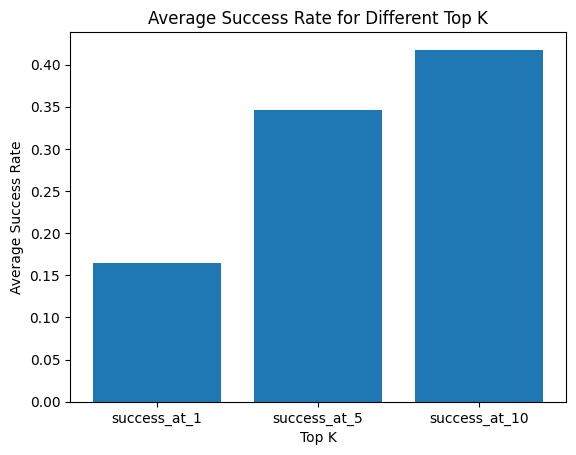

In [31]:
avg_success = average_success_top_k(success)
plt.bar(avg_success.keys(), avg_success.values())

plt.xlabel('Top K')
plt.ylabel('Average Success Rate')
plt.title('Average Success Rate for Different Top K')
plt.show()
# print(pd.DataFrame.from_dict(data_dict, orient='index'))